### Analyse entire data

In this notebook I analysed the offers for the sample dataset provided from EPEX Spot API.

           price_per_mwh                                                    \
                   count        mean          std           min        25%   
date                                                                         
2021-06-26      403957.0  302.550519   772.094052 -60040.000000  15.517241   
2021-06-27     1417420.0  363.480786  1100.858005 -40026.666667  14.285882   

                                            
                  50%         75%      max  
date                                        
2021-06-26  80.570000  248.909091  60040.0  
2021-06-27  64.493333  292.000000  75840.0  


<Figure size 1200x600 with 0 Axes>

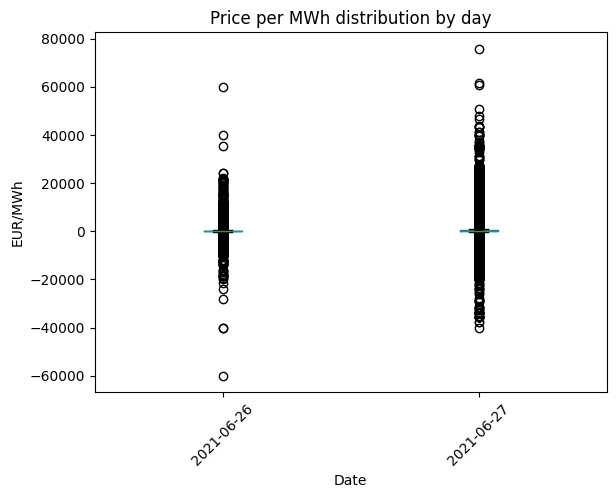

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the CSV (adjust the filename/path)
df = pd.read_csv('../data/Continuous_Orders-DE-20210627-20210628T042307000Z.csv')

# Convert TransactionTime to datetime (if it's not already)
df["TransactionTime"] = pd.to_datetime(df["TransactionTime"], errors="coerce")

# Step 1: Keep only the latest revision for each OrderId
df = df.sort_values(by=["OrderId", "RevisionNo"], ascending=[True, False]).drop_duplicates(subset=["OrderId"], keep="first")

# Step 2: Remove orders that never became a transaction (TransactionTime is NaN)
df = df[df["TransactionTime"].notna()]

df = df[(df["Price"] != 0) & (df["Volume"] != 0)]

# 2) Convert DeliveryStart to a datetime
df["CreationTime"] = pd.to_datetime(df["CreationTime"], errors="coerce")


# 3) Create a "date" column (based on DeliveryStart) to group by day
df["date"] = df["CreationTime"].dt.date

# 4) Convert Price and Volume to floats (if they aren't already)
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# 5) Calculate price per MWh (if "Price" is total for 'Volume' MWh)
df["price_per_mwh"] = df["Price"] / df["Volume"]

# 6) Drop any rows with missing or invalid values
df.dropna(subset=["price_per_mwh"], inplace=True)

# 7) Check basic stats
print(df[["date", "price_per_mwh"]].groupby("date").describe())

# 8) Plot a distribution (boxplot) of prices per day
plt.figure(figsize=(12,6))
df.boxplot(column="price_per_mwh", by="date", grid=False, rot=45)
plt.title("Price per MWh distribution by day")
plt.suptitle("")  # Remove default title
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.show()


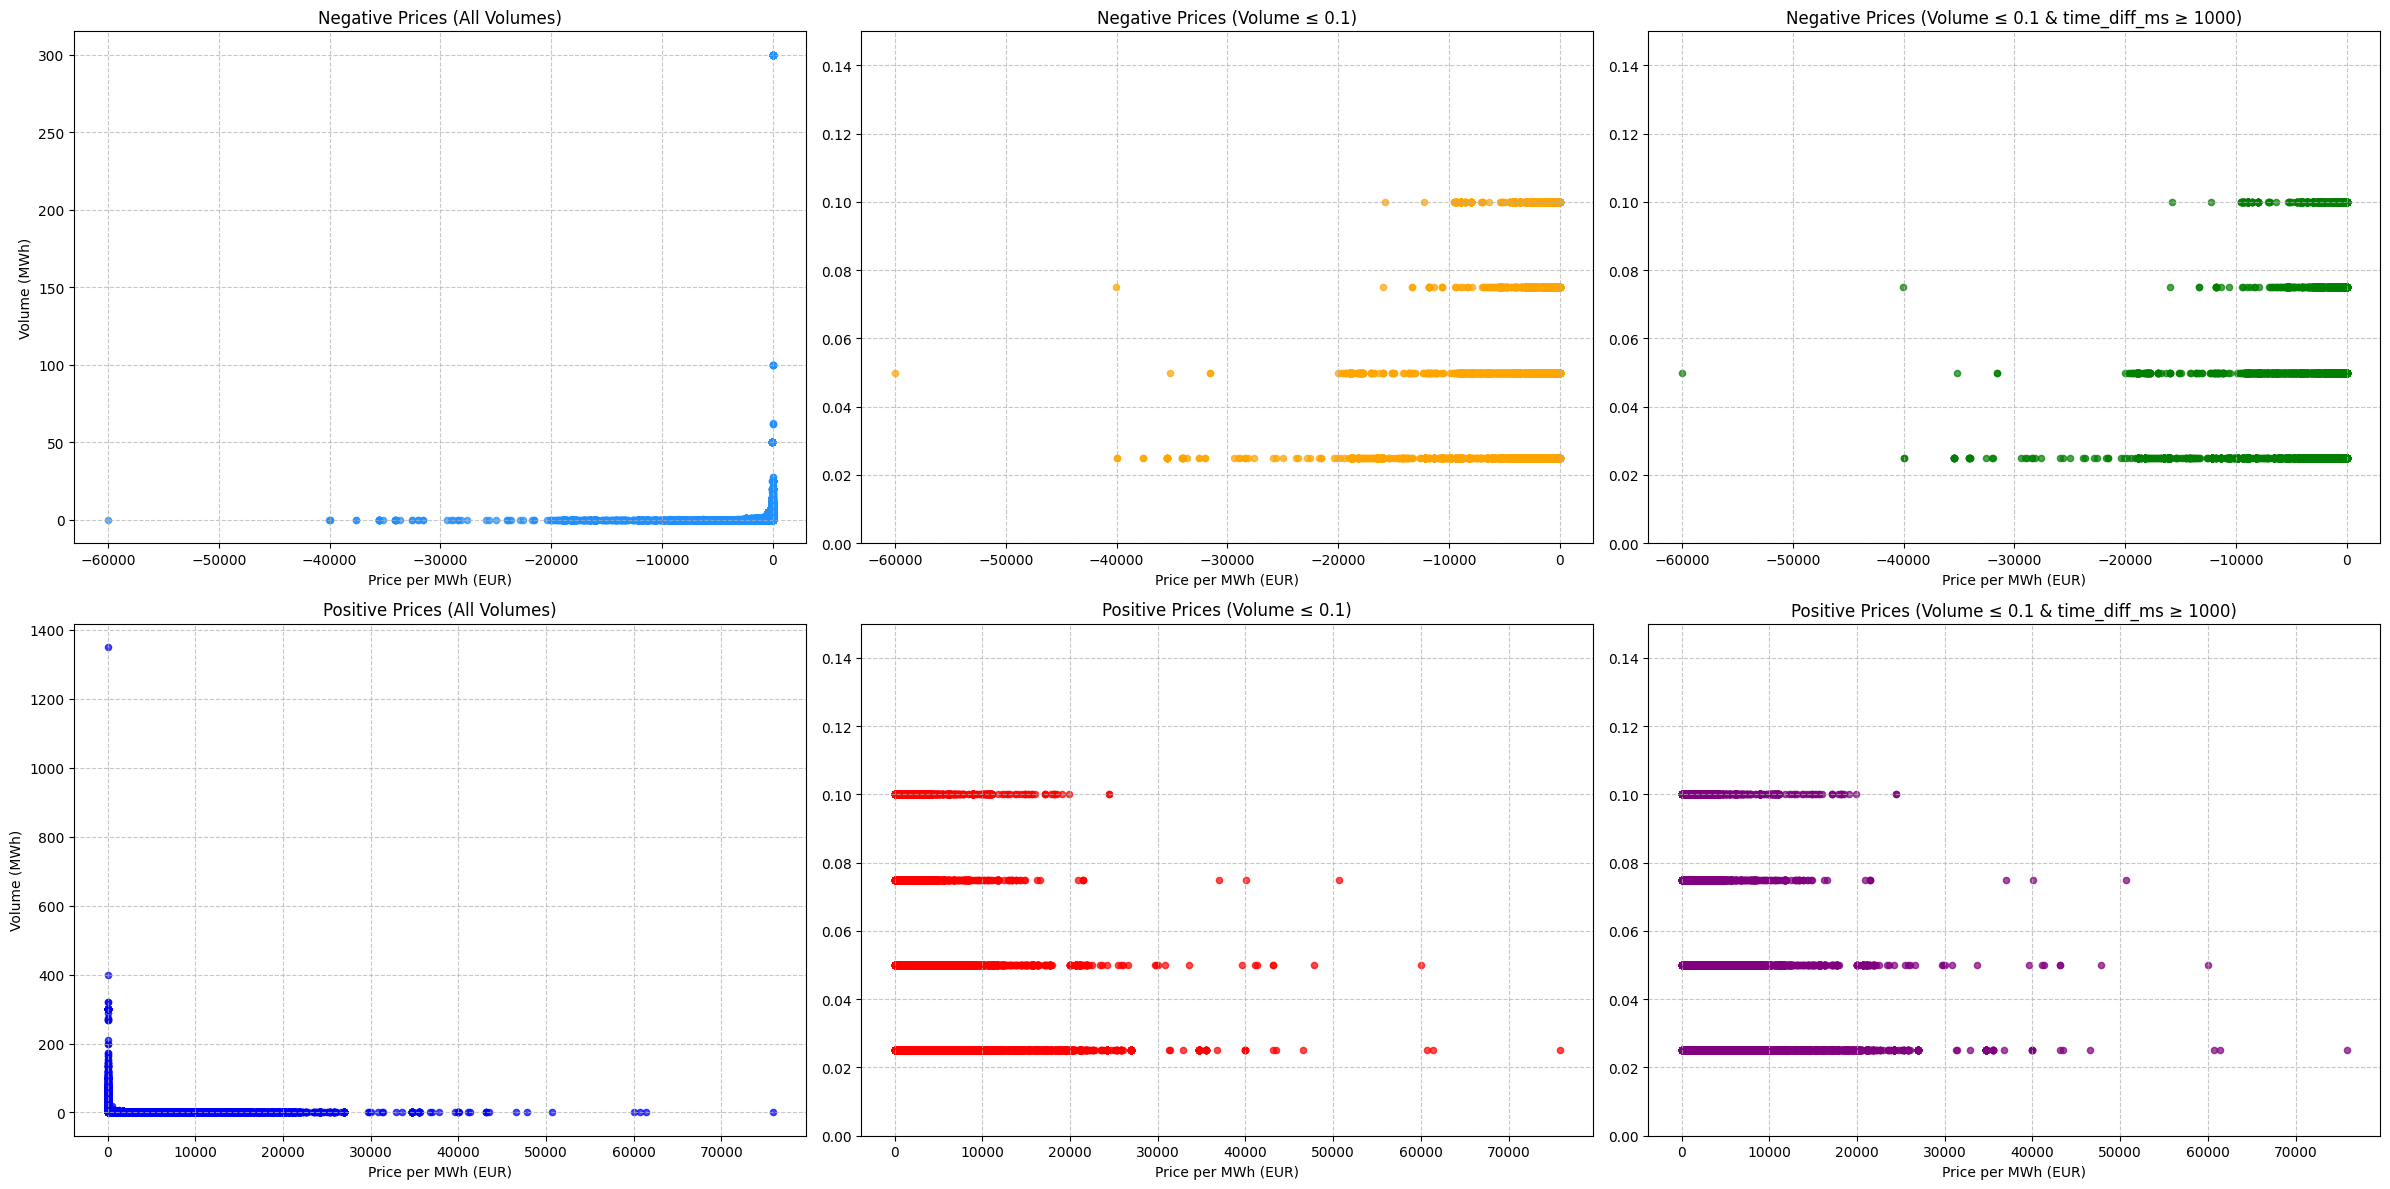

Summary Table for Negative Prices:
                 Metric        Value
0     Total Count (Neg)      9920.00
1    Total Volume (Neg)       536.15
2  Total Negative Price -21996068.90

Summary Table for Positive Prices:
                 Metric         Value
0     Total Count (Pos)  2.532410e+05
1    Total Volume (Pos)  1.425187e+04
2  Total Positive Price  4.303836e+08


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert columns to datetime if not done yet
df["CreationTime"] = pd.to_datetime(df["CreationTime"], errors="coerce")
df["TransactionTime"] = pd.to_datetime(df["TransactionTime"], errors="coerce")

# Calculate the time difference in milliseconds
df["time_diff_ms"] = (df["TransactionTime"].astype("int64") - df["CreationTime"].astype("int64")) // 1_000_000

### Handling Negative Prices ###
negative_prices = df[df['price_per_mwh'] < 0]
filtered_negative = negative_prices[negative_prices["Volume"] <= 0.1]
filtered_negative_large_time_diff = filtered_negative[filtered_negative["time_diff_ms"] >= 1000]

# Sorting
sorted_negative = negative_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_filtered_negative = filtered_negative.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_large_time_diff_negative = filtered_negative_large_time_diff.sort_values(by="price_per_mwh", ascending=False).reset_index()

### Handling Positive Prices ###
positive_prices = df[df['price_per_mwh'] > 0]
filtered_positive = positive_prices[positive_prices["Volume"] <= 0.1]
filtered_positive_large_time_diff = filtered_positive[filtered_positive["time_diff_ms"] >= 1000]

# Sorting
sorted_positive = positive_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_filtered_positive = filtered_positive.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_large_time_diff_positive = filtered_positive_large_time_diff.sort_values(by="price_per_mwh", ascending=False).reset_index()

# Create six subplots (3 for negative prices, 3 for positive prices)
fig, axes = plt.subplots(2, 3, figsize=(24, 12), sharey=False)

# Plot 1: All negative prices
axes[0, 0].scatter(
    sorted_negative["price_per_mwh"],
    sorted_negative["Volume"],
    alpha=0.7,
    s=20,
    color='dodgerblue'
)
axes[0, 0].set_title("Negative Prices (All Volumes)")
axes[0, 0].set_xlabel("Price per MWh (EUR)")
axes[0, 0].set_ylabel("Volume (MWh)")
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Negative prices with Volume ≤ 0.1
axes[0, 1].scatter(
    sorted_filtered_negative["price_per_mwh"],
    sorted_filtered_negative["Volume"],
    alpha=0.7,
    s=20,
    color='orange'
)
axes[0, 1].set_title("Negative Prices (Volume ≤ 0.1)")
axes[0, 1].set_xlabel("Price per MWh (EUR)")
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].set_ylim(0, 0.15)

# Plot 3: Negative prices with Volume ≤ 0.1 & time_diff_ms ≥ 1000
axes[0, 2].scatter(
    sorted_large_time_diff_negative["price_per_mwh"],
    sorted_large_time_diff_negative["Volume"],
    alpha=0.7,
    s=20,
    color='green'
)
axes[0, 2].set_title("Negative Prices (Volume ≤ 0.1 & time_diff_ms ≥ 1000)")
axes[0, 2].set_xlabel("Price per MWh (EUR)")
axes[0, 2].grid(True, linestyle='--', alpha=0.7)
axes[0, 2].set_ylim(0, 0.15)

# Plot 4: All positive prices
axes[1, 0].scatter(
    sorted_positive["price_per_mwh"],
    sorted_positive["Volume"],
    alpha=0.7,
    s=20,
    color='blue'
)
axes[1, 0].set_title("Positive Prices (All Volumes)")
axes[1, 0].set_xlabel("Price per MWh (EUR)")
axes[1, 0].set_ylabel("Volume (MWh)")
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Plot 5: Positive prices with Volume ≤ 0.1
axes[1, 1].scatter(
    sorted_filtered_positive["price_per_mwh"],
    sorted_filtered_positive["Volume"],
    alpha=0.7,
    s=20,
    color='red'
)
axes[1, 1].set_title("Positive Prices (Volume ≤ 0.1)")
axes[1, 1].set_xlabel("Price per MWh (EUR)")
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].set_ylim(0, 0.15)

# Plot 6: Positive prices with Volume ≤ 0.1 & time_diff_ms ≥ 1000
axes[1, 2].scatter(
    sorted_large_time_diff_positive["price_per_mwh"],
    sorted_large_time_diff_positive["Volume"],
    alpha=0.7,
    s=20,
    color='purple'
)
axes[1, 2].set_title("Positive Prices (Volume ≤ 0.1 & time_diff_ms ≥ 1000)")
axes[1, 2].set_xlabel("Price per MWh (EUR)")
axes[1, 2].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].set_ylim(0, 0.15)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Summary table for transactions with time_diff_ms >= 1000 ms (Negative Prices)
total_count_neg = len(filtered_negative_large_time_diff)
total_volume_neg = filtered_negative_large_time_diff["Volume"].sum()
total_negative_price = filtered_negative_large_time_diff["price_per_mwh"].sum()

summary_table_neg = pd.DataFrame({
    "Metric": ["Total Count (Neg)", "Total Volume (Neg)", "Total Negative Price"],
    "Value": [total_count_neg, total_volume_neg, total_negative_price]
})

# Summary table for transactions with time_diff_ms >= 1000 ms (Positive Prices)
total_count_pos = len(filtered_positive_large_time_diff)
total_volume_pos = filtered_positive_large_time_diff["Volume"].sum()
total_positive_price = filtered_positive_large_time_diff["price_per_mwh"].sum()

summary_table_pos = pd.DataFrame({
    "Metric": ["Total Count (Pos)", "Total Volume (Pos)", "Total Positive Price"],
    "Value": [total_count_pos, total_volume_pos, total_positive_price]
})

# Print the summary tables
print("Summary Table for Negative Prices:")
print(summary_table_neg)
print("\nSummary Table for Positive Prices:")
print(summary_table_pos)


The graphs above display the following:
1. Distribution of all negative transactions
2. Distribution of all negative transactions where the volume is below or equal to 100kWH
3. Distribution of all negative transactions where the volume is below or equal to 100kWH and the timeframe between creation and transactio of the over is bigger than 1000ms or 1s

In [3]:
relevant_metrics = filtered_negative_large_time_diff[['Price','Quantity','Volume','price_per_mwh','time_diff_ms']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T
relevant_metrics.rename(columns={
    "count": "Total Count",
    "mean": "Mean",
    "std": "Standard Deviation",
    "min": "Minimum",
    "10%": "10th Percentile",
    "25%": "25th Percentile",
    "50%": "Median",
    "75%": "75th Percentile",
    "90%": "90th Percentile",
    "95%": "95th Percentile",
    "99%": "99th Percentile",
    "max": "Maximum"
}, inplace=True)

# Convert to a well-formatted table
relevant_metrics.reset_index(inplace=True)
relevant_metrics.rename(columns={"index": "Metric"}, inplace=True)

# Display the table
#print(relevant_metrics)


# Define the quantile probabilities including the full range
quantile_probs = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Calculate bin edges based on quantiles
quantile_bins = filtered_negative_large_time_diff['Price'].quantile(quantile_probs).values

# Create labels using the quantile percentages (e.g. "0%-10%", "10%-25%", etc.)
quantile_labels = [f"{int(p*100)}%-{int(q*100)}%" for p, q in zip(quantile_probs, quantile_probs[1:])]

print(f"Number of bin edges: {len(quantile_bins)}, Number of labels: {len(quantile_labels)}")

# Bin the Price data into quantile ranges
filtered_negative_large_time_diff["Price_Quantile"] = pd.cut(
    filtered_negative_large_time_diff["Price"], 
    bins=quantile_bins, 
    labels=quantile_labels,
    include_lowest=True
)

# Group by quantile range and calculate the sum of Price and Volume
quantile_summary = filtered_negative_large_time_diff.groupby("Price_Quantile").agg(
    Total_Volume=("Volume", "sum"),
    Total_Price=("Price", "sum")
).reset_index()

# Display the summary table
print(quantile_summary)

Number of bin edges: 9, Number of labels: 8
  Price_Quantile  Total_Volume  Total_Price
0          0%-1%         9.150   -129557.51
1          1%-5%        18.350   -192963.87
2         5%-10%        26.725   -167926.98
3        10%-25%        73.825   -227477.12
4        25%-50%       126.525   -132717.86
5        50%-75%       132.125    -48925.26
6        75%-90%        98.325    -10646.39
7       90%-100%        51.125     -2318.06


/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/32035266.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_negative_large_time_diff["Price_Quantile"] = pd.cut(
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/32035266.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_summary = filtered_negative_large_time_diff.groupby("Price_Quantile").agg(


In [4]:
relevant_metrics = filtered_positive_large_time_diff[['Price','Quantity','Volume','price_per_mwh','time_diff_ms']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T
relevant_metrics.rename(columns={
    "count": "Total Count",
    "mean": "Mean",
    "std": "Standard Deviation",
    "min": "Minimum",
    "10%": "10th Percentile",
    "25%": "25th Percentile",
    "50%": "Median",
    "75%": "75th Percentile",
    "90%": "90th Percentile",
    "95%": "95th Percentile",
    "99%": "99th Percentile",
    "max": "Maximum"
}, inplace=True)

# Convert to a well-formatted table
relevant_metrics.reset_index(inplace=True)
relevant_metrics.rename(columns={"index": "Metric"}, inplace=True)

# Display the table
#print(relevant_metrics)


# Define the quantile probabilities including the full range
quantile_probs = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Calculate bin edges based on quantiles
quantile_bins = filtered_positive_large_time_diff['Price'].quantile(quantile_probs).values

# Create labels using the quantile percentages (e.g. "0%-10%", "10%-25%", etc.)
quantile_labels = [f"{int(p*100)}%-{int(q*100)}%" for p, q in zip(quantile_probs, quantile_probs[1:])]

print(f"Number of bin edges: {len(quantile_bins)}, Number of labels: {len(quantile_labels)}")

# Bin the Price data into quantile ranges
filtered_positive_large_time_diff["Price_Quantile"] = pd.cut(
    filtered_positive_large_time_diff["Price"], 
    bins=quantile_bins, 
    labels=quantile_labels,
    include_lowest=True
)

# Group by quantile range and calculate the sum of Price and Volume
quantile_summary = filtered_positive_large_time_diff.groupby("Price_Quantile").agg(
    Total_Volume=("Volume", "sum"),
    Total_Price=("Price", "sum")
).reset_index()

# Display the summary table
print(quantile_summary)

Number of bin edges: 9, Number of labels: 8
  Price_Quantile  Total_Volume  Total_Price
0          0%-1%       132.800      7170.69
1          1%-5%       573.125    141508.52
2         5%-10%       713.300    330432.12
3        10%-25%      2156.800   1526493.56
4        25%-50%      3606.125   3470535.59
5        50%-75%      3461.975   4544068.70
6        75%-90%      2193.225   3649550.20
7       90%-100%      1414.525   4431430.18


/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/2094018555.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_positive_large_time_diff["Price_Quantile"] = pd.cut(
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/2094018555.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_summary = filtered_positive_large_time_diff.groupby("Price_Quantile").agg(


### Analyse Sell Offers
Using the same analysation method but only for transactions that were put on the market for sell.

           price_per_mwh                                                   \
                   count        mean          std     min     25%     50%   
date                                                                        
2021-06-26      217050.0  383.050940   826.018298 -1100.0  27.450  107.10   
2021-06-27      640772.0  499.437525  1311.460059 -4724.0  16.925   81.34   

                                 
                   75%      max  
date                             
2021-06-26  303.562727  60040.0  
2021-06-27  398.000000  75840.0  


<Figure size 1200x600 with 0 Axes>

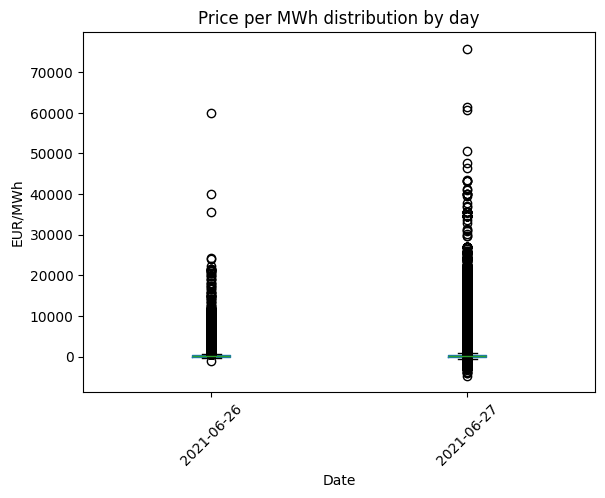

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the CSV (adjust the filename/path)
df_sell = df[df["Side"] == 'SELL']

# 7) Check basic stats
print(df_sell[["date", "price_per_mwh"]].groupby("date").describe())

# 8) Plot a distribution (boxplot) of prices per day
plt.figure(figsize=(12,6))
df_sell.boxplot(column="price_per_mwh", by="date", grid=False, rot=45)
plt.title("Price per MWh distribution by day")
plt.suptitle("")  # Remove default title
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.show()


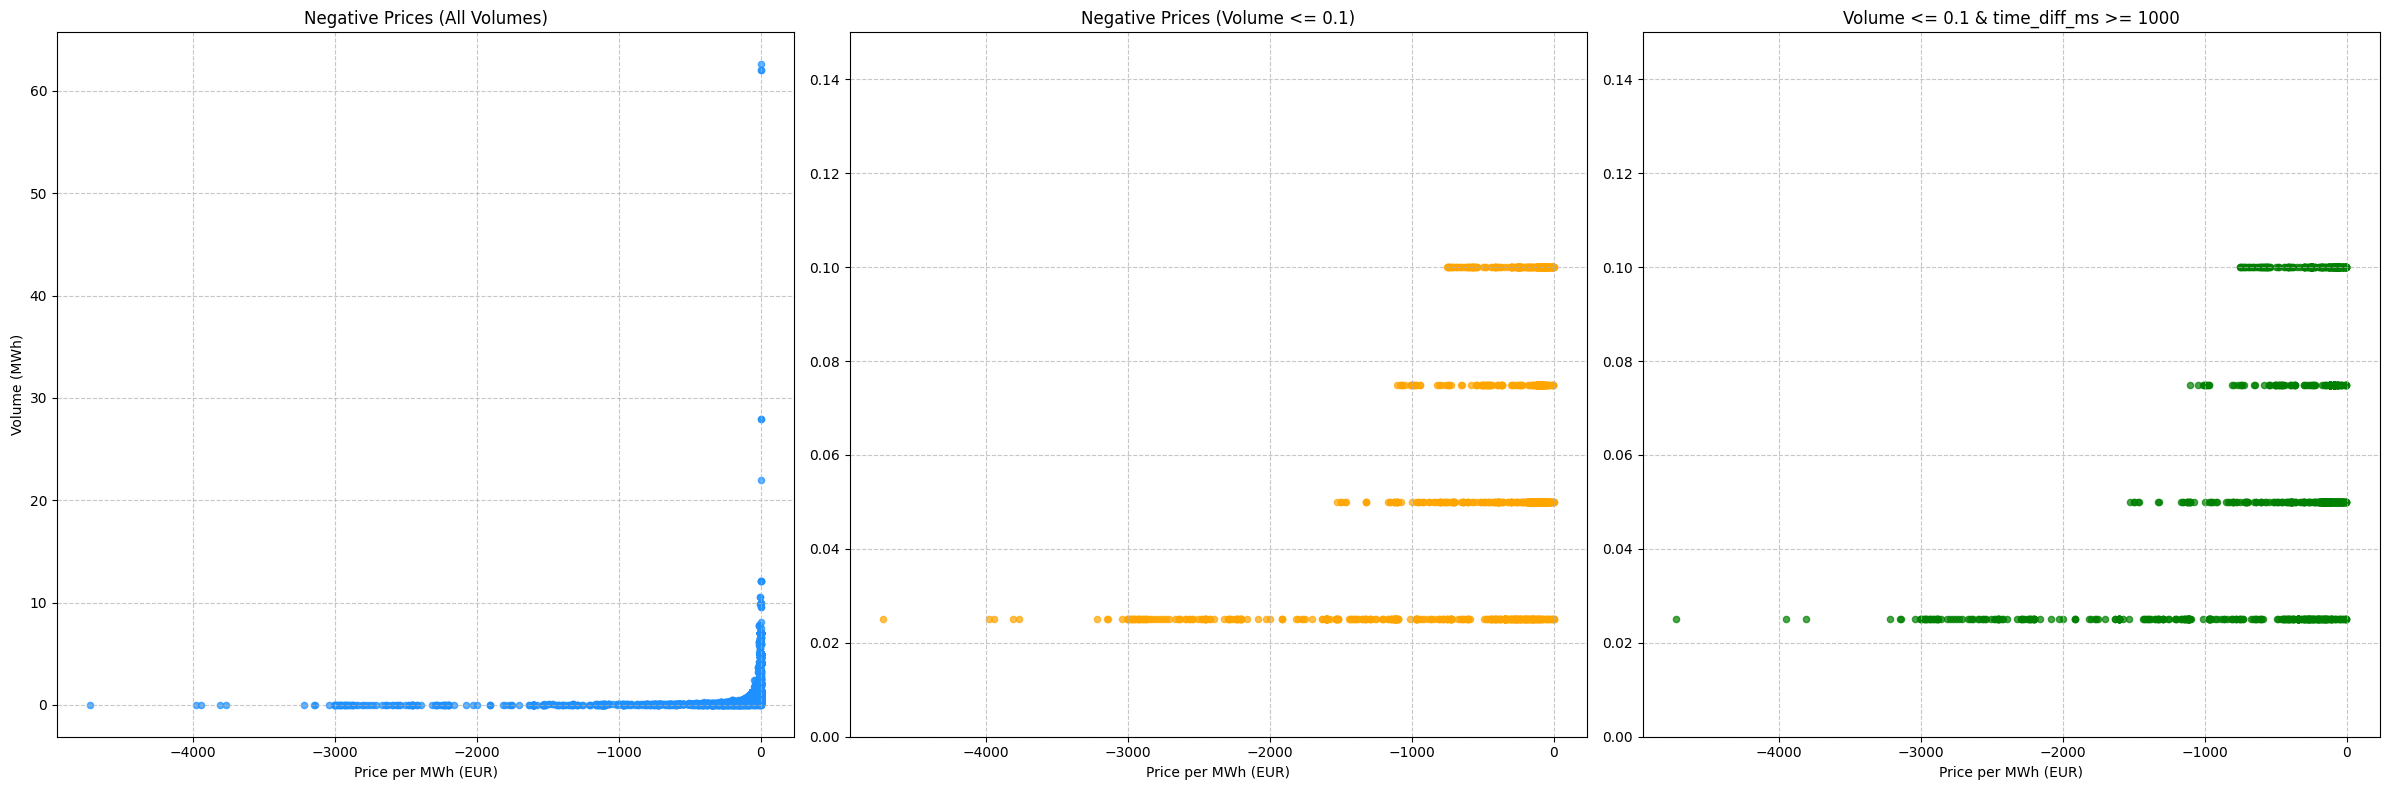

                 Metric      Value
0           Total Count   1485.000
1          Total Volume    103.275
2  Total Negative Price -25744.560


In [6]:
# Filter for negative prices
negative_prices = df_sell[df_sell['price_per_mwh'] < 0]

# Filter for negative prices with Volume <= 0.1
filtered_prices = negative_prices[negative_prices["Volume"] <= 0.1]

# Additional filter: Transactions with time_diff_ms >= 1000 ms
filtered_large_time_diff = filtered_prices[filtered_prices["time_diff_ms"] >= 1000]

# Ensure all datasets are sorted by price_per_mwh in descending order
sorted_df = negative_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_filtered_df = filtered_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_large_time_diff = filtered_large_time_diff.sort_values(by="price_per_mwh", ascending=False).reset_index()

# Create three subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=False)

# Plot 1: All negative prices
axes[0].scatter(
    sorted_df["price_per_mwh"],
    sorted_df["Volume"],
    alpha=0.7,
    s=20,
    color='dodgerblue'
)
axes[0].set_title("Negative Prices (All Volumes)")
axes[0].set_xlabel("Price per MWh (EUR)")
axes[0].set_ylabel("Volume (MWh)")
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Negative prices with Volume <= 0.1
axes[1].scatter(
    sorted_filtered_df["price_per_mwh"],
    sorted_filtered_df["Volume"],
    alpha=0.7,
    s=20,
    color='orange'
)
axes[1].set_title("Negative Prices (Volume <= 0.1)")
axes[1].set_xlabel("Price per MWh (EUR)")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_ylim(0, 0.15)  # Adjust y-axis for smaller volumes

# Plot 3: Filtered transactions with time_diff_ms >= 1000 ms
axes[2].scatter(
    sorted_large_time_diff["price_per_mwh"],
    sorted_large_time_diff["Volume"],
    alpha=0.7,
    s=20,
    color='green'
)
axes[2].set_title("Volume <= 0.1 & time_diff_ms >= 1000")
axes[2].set_xlabel("Price per MWh (EUR)")
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_ylim(0, 0.15)  # Adjust y-axis for smaller volumes

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Summary table for transactions with time_diff_ms >= 1000 ms
total_count = len(filtered_large_time_diff)
total_volume = filtered_large_time_diff["Volume"].sum()
total_negative_price = filtered_large_time_diff["Price"].sum()

# Create and print the summary table
summary_table = pd.DataFrame({
    "Metric": ["Total Count", "Total Volume", "Total Negative Price"],
    "Value": [total_count, total_volume, total_negative_price]
})

print(summary_table)

In [7]:
import pandas as pd

# Define the quantile probabilities including the full range
quantile_probs = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Calculate bin edges based on quantiles
quantile_bins = filtered_large_time_diff['Price'].quantile(quantile_probs).values

# Create labels using the quantile percentages (e.g. "0%-10%", "10%-25%", etc.)
quantile_labels = [f"{int(p*100)}%-{int(q*100)}%" for p, q in zip(quantile_probs, quantile_probs[1:])]

print(f"Number of bin edges: {len(quantile_bins)}, Number of labels: {len(quantile_labels)}")

# Bin the Price data into quantile ranges
filtered_large_time_diff["Price_Quantile"] = pd.cut(
    filtered_large_time_diff["Price"], 
    bins=quantile_bins, 
    labels=quantile_labels,
    include_lowest=True
)

# Group by quantile range and calculate the sum of Price and Volume
quantile_summary = filtered_large_time_diff.groupby("Price_Quantile").agg(
    Total_Volume=("Volume", "sum"),
    Total_Price=("Price", "sum")
).reset_index()

# Display the summary table
print(quantile_summary)


Number of bin edges: 9, Number of labels: 8
  Price_Quantile  Total_Volume  Total_Price
0          0%-1%         0.725     -1389.47
1          1%-5%         2.975     -4173.29
2         5%-10%         4.100     -4329.55
3        10%-25%        13.600     -7494.38
4        25%-50%        22.200     -4681.59
5        50%-75%        31.475     -2242.27
6        75%-90%        20.100     -1132.53
7       90%-100%         8.100      -301.48


/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/3343403287.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_large_time_diff["Price_Quantile"] = pd.cut(
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/3343403287.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_summary = filtered_large_time_diff.groupby("Price_Quantile").agg(


### Analye BUY Offers
Using the same analysation method but only for transactions that were put on the market to buy.

           price_per_mwh                                                   \
                   count        mean         std           min        25%   
date                                                                        
2021-06-26      186907.0  209.067576  692.670753 -60040.000000  11.692000   
2021-06-27      776648.0  251.309929  874.585928 -40026.666667  11.727708   

                                        
              50%         75%      max  
date                                    
2021-06-26  59.71  196.340659   5010.8  
2021-06-27  52.34  220.622222  12080.4  


<Figure size 1200x600 with 0 Axes>

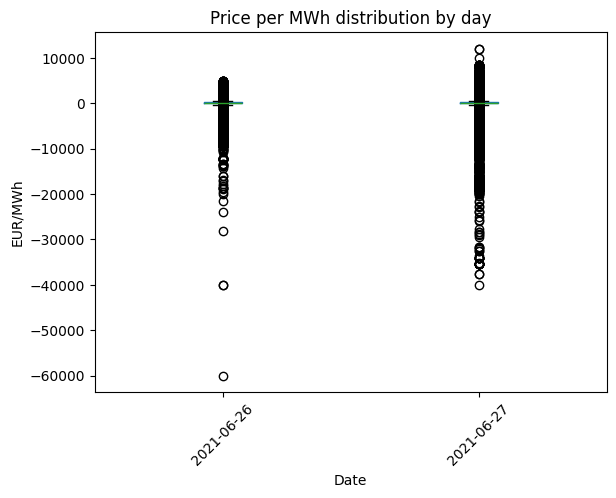

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the CSV (adjust the filename/path)
df_buy = df[df["Side"] == 'BUY']

# 7) Check basic stats
print(df_buy[["date", "price_per_mwh"]].groupby("date").describe())

# 8) Plot a distribution (boxplot) of prices per day
plt.figure(figsize=(12,6))
df_buy.boxplot(column="price_per_mwh", by="date", grid=False, rot=45)
plt.title("Price per MWh distribution by day")
plt.suptitle("")  # Remove default title
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.show()


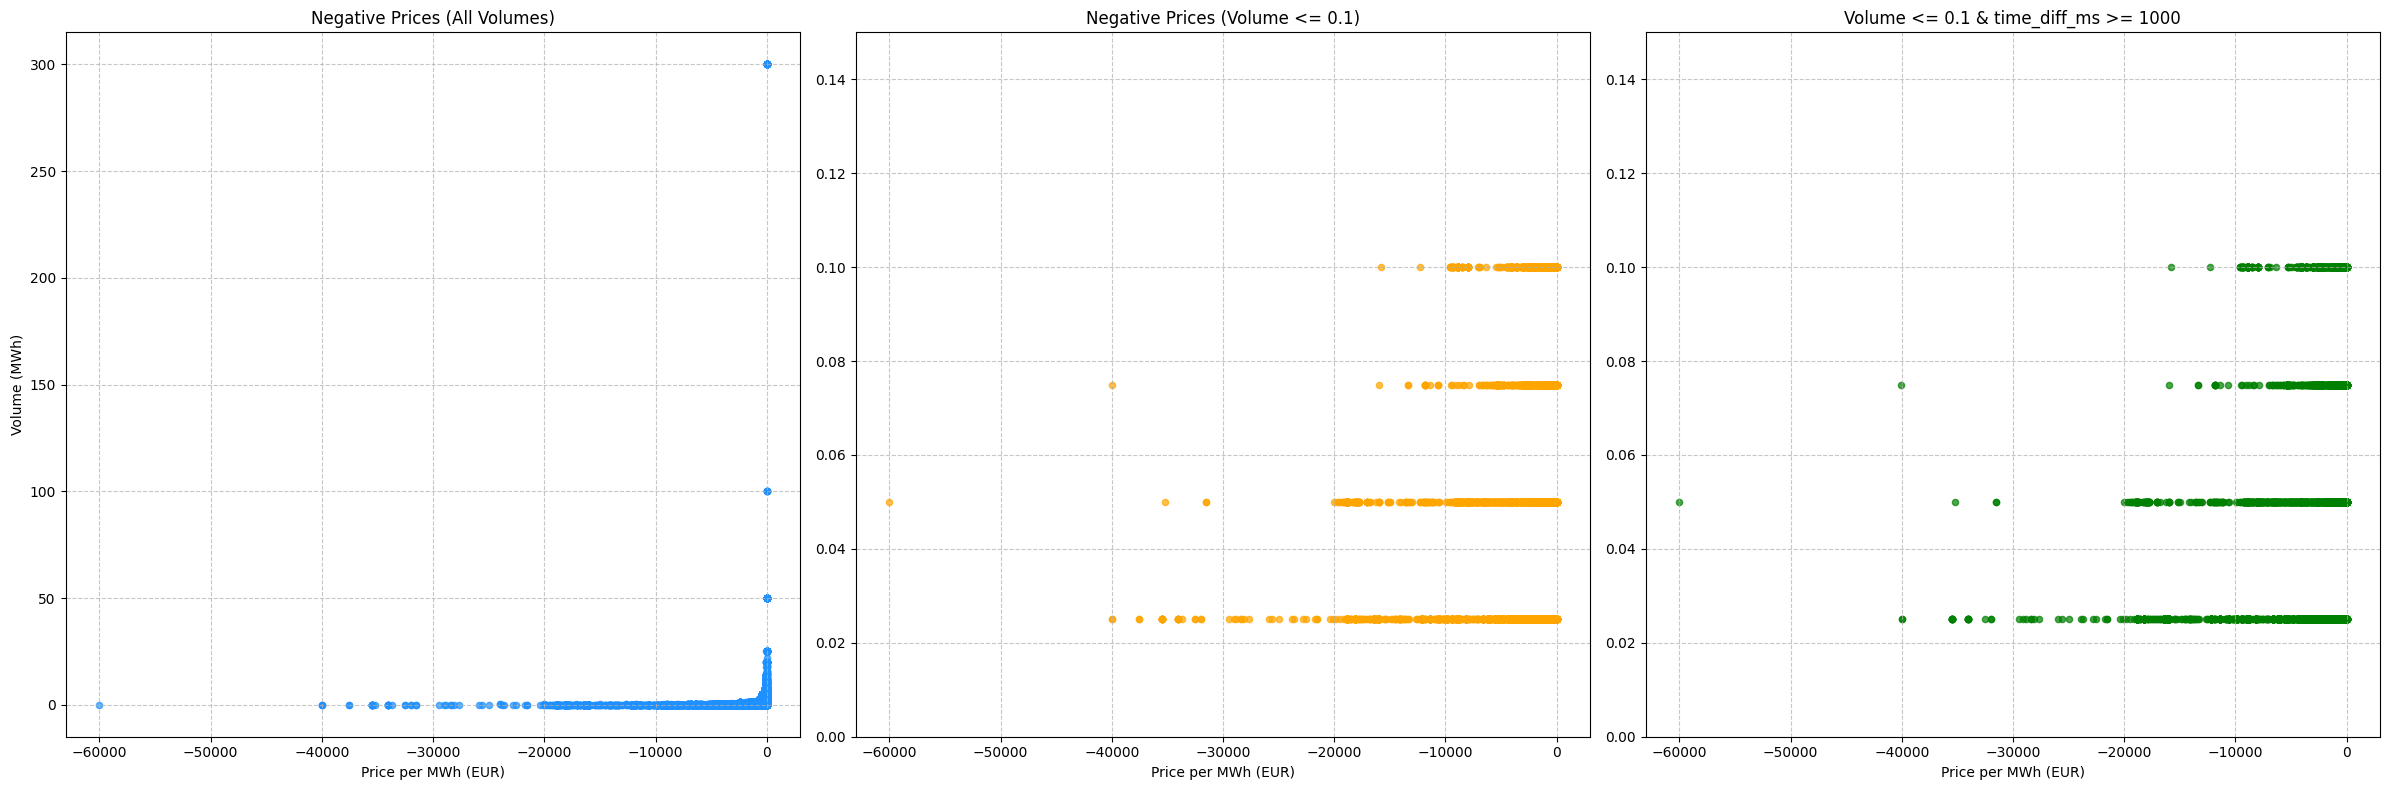

                 Metric       Value
0           Total Count    8435.000
1          Total Volume     432.875
2  Total Negative Price -886788.490


In [9]:
# Filter for negative prices
negative_prices = df_buy[df_buy['price_per_mwh'] < 0]

# Filter for negative prices with Volume <= 0.1
filtered_prices = negative_prices[negative_prices["Volume"] <= 0.1]

# Additional filter: Transactions with time_diff_ms >= 1000 ms
filtered_large_time_diff = filtered_prices[filtered_prices["time_diff_ms"] >= 1000]

# Ensure all datasets are sorted by price_per_mwh in descending order
sorted_df = negative_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_filtered_df = filtered_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_large_time_diff = filtered_large_time_diff.sort_values(by="price_per_mwh", ascending=False).reset_index()

# Create three subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=False)

# Plot 1: All negative prices
axes[0].scatter(
    sorted_df["price_per_mwh"],
    sorted_df["Volume"],
    alpha=0.7,
    s=20,
    color='dodgerblue'
)
axes[0].set_title("Negative Prices (All Volumes)")
axes[0].set_xlabel("Price per MWh (EUR)")
axes[0].set_ylabel("Volume (MWh)")
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Negative prices with Volume <= 0.1
axes[1].scatter(
    sorted_filtered_df["price_per_mwh"],
    sorted_filtered_df["Volume"],
    alpha=0.7,
    s=20,
    color='orange'
)
axes[1].set_title("Negative Prices (Volume <= 0.1)")
axes[1].set_xlabel("Price per MWh (EUR)")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_ylim(0, 0.15)  # Adjust y-axis for smaller volumes

# Plot 3: Filtered transactions with time_diff_ms >= 1000 ms
axes[2].scatter(
    sorted_large_time_diff["price_per_mwh"],
    sorted_large_time_diff["Volume"],
    alpha=0.7,
    s=20,
    color='green'
)
axes[2].set_title("Volume <= 0.1 & time_diff_ms >= 1000")
axes[2].set_xlabel("Price per MWh (EUR)")
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_ylim(0, 0.15)  # Adjust y-axis for smaller volumes

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Summary table for transactions with time_diff_ms >= 1000 ms
total_count = len(filtered_large_time_diff)
total_volume = filtered_large_time_diff["Volume"].sum()
total_negative_price = filtered_large_time_diff["Price"].sum()

# Create and print the summary table
summary_table = pd.DataFrame({
    "Metric": ["Total Count", "Total Volume", "Total Negative Price"],
    "Value": [total_count, total_volume, total_negative_price]
})

print(summary_table)

In [10]:
import pandas as pd

# Define the quantile probabilities including the full range
quantile_probs = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Calculate bin edges based on quantiles
quantile_bins = filtered_large_time_diff['Price'].quantile(quantile_probs).values

# Create labels using the quantile percentages (e.g. "0%-10%", "10%-25%", etc.)
quantile_labels = [f"{int(p*100)}%-{int(q*100)}%" for p, q in zip(quantile_probs, quantile_probs[1:])]

print(f"Number of bin edges: {len(quantile_bins)}, Number of labels: {len(quantile_labels)}")

# Bin the Price data into quantile ranges
filtered_large_time_diff["Price_Quantile"] = pd.cut(
    filtered_large_time_diff["Price"], 
    bins=quantile_bins, 
    labels=quantile_labels,
    include_lowest=True
)

# Group by quantile range and calculate the sum of Price and Volume
quantile_summary = filtered_large_time_diff.groupby("Price_Quantile").agg(
    Total_Volume=("Volume", "sum"),
    Total_Price=("Price", "sum")
).reset_index()

# Display the summary table
print(quantile_summary)

Number of bin edges: 9, Number of labels: 8
  Price_Quantile  Total_Volume  Total_Price
0          0%-1%         5.500    -86954.92
1          1%-5%        18.225   -203470.52
2         5%-10%        23.625   -157521.95
3        10%-25%        63.750   -238602.29
4        25%-50%       106.600   -132862.28
5        50%-75%       110.150    -52974.27
6        75%-90%        62.050    -12384.73
7       90%-100%        42.975     -2017.53


/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/1537614606.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_large_time_diff["Price_Quantile"] = pd.cut(
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/1537614606.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_summary = filtered_large_time_diff.groupby("Price_Quantile").agg(


## Analyse with respect to volume per hour for relevant offers

/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/2515764550.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_prices["DeliveryStart"] = pd.to_datetime(negative_prices["DeliveryStart"], errors="coerce")
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/2515764550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_prices["DeliveryEnd"] = pd.to_datetime(negative_prices["DeliveryEnd"], errors="coerce")
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel

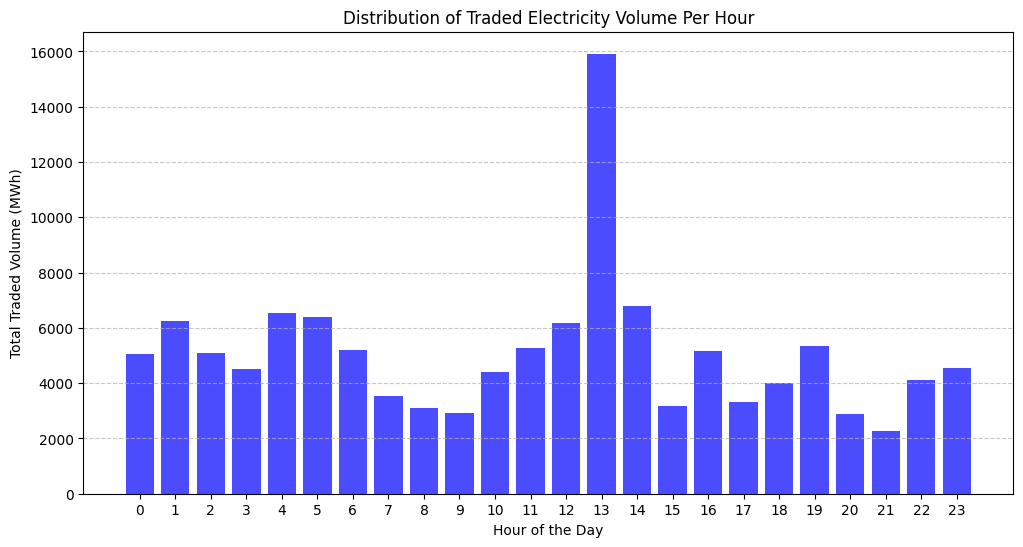

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert timestamps to datetime format
negative_prices["DeliveryStart"] = pd.to_datetime(negative_prices["DeliveryStart"], errors="coerce")
negative_prices["DeliveryEnd"] = pd.to_datetime(negative_prices["DeliveryEnd"], errors="coerce")

# Extract the hour of the delivery start time
negative_prices["Hour"] = negative_prices["DeliveryStart"].dt.hour

# Group by hour and sum the traded volumes
hourly_volume = negative_prices.groupby("Hour")["Volume"].sum().reset_index()

# Plot the distribution of traded volumes per hour
plt.figure(figsize=(12, 6))
plt.bar(hourly_volume["Hour"], hourly_volume["Volume"], color="blue", alpha=0.7)
plt.xlabel("Hour of the Day")
plt.ylabel("Total Traded Volume (MWh)")
plt.title("Distribution of Traded Electricity Volume Per Hour")
plt.xticks(range(24))  # Ensure x-axis shows all hours (0-23)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/2398068951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_prices["DeliveryStart"] = pd.to_datetime(negative_prices["DeliveryStart"], errors="coerce")
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/2398068951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_prices["DeliveryEnd"] = pd.to_datetime(negative_prices["DeliveryEnd"], errors="coerce")
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel

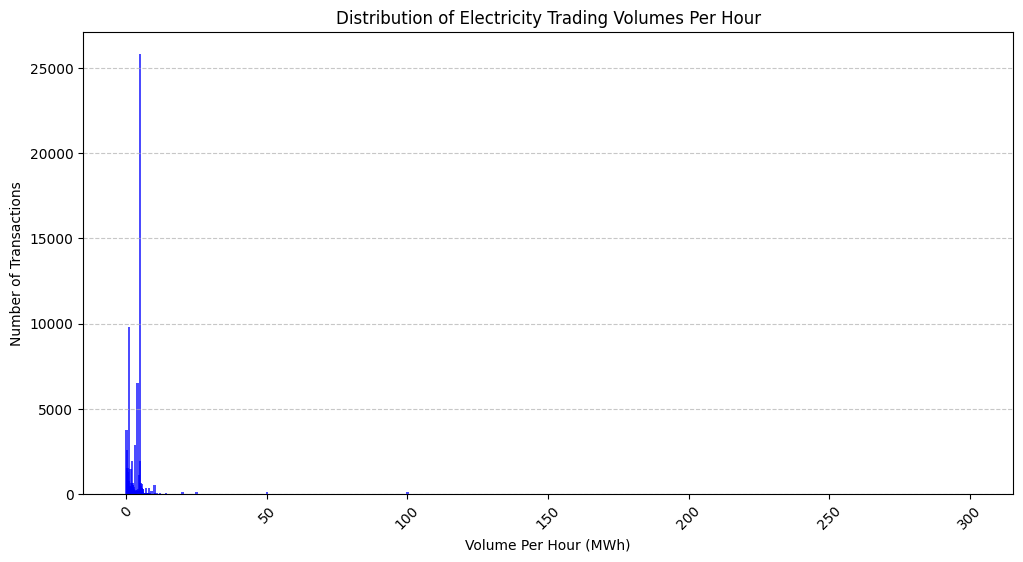

     Volume_Per_Hour  Count
3                0.1   3782
5                0.2   2601
9                0.3   1542
8                0.4   1564
11               0.5   1323
..               ...    ...
119             47.0      8
120             48.0      8
60              50.0    132
63             100.0    125
91             300.0     29

[190 rows x 2 columns]
       Volume_Per_Hour         Count
count       190.000000    190.000000
mean         12.513158    432.421053
std          23.445614   2087.988108
min           0.100000      1.000000
25%           4.825000      4.000000
50%           9.550000     25.000000
75%          14.350000    209.250000
max         300.000000  25808.000000


In [37]:
# Ensure timestamps are in datetime format
negative_prices["DeliveryStart"] = pd.to_datetime(negative_prices["DeliveryStart"], errors="coerce")
negative_prices["DeliveryEnd"] = pd.to_datetime(negative_prices["DeliveryEnd"], errors="coerce")

# Calculate the duration of the transaction in hours
negative_prices["Duration_Hours"] = (negative_prices["DeliveryEnd"] - negative_prices["DeliveryStart"]).dt.total_seconds() / 3600

# Remove invalid durations (avoid division by zero)
relevant_rows = negative_prices[negative_prices["Duration_Hours"] > 0]

# Calculate the volume per hour
relevant_rows["Volume_Per_Hour"] = relevant_rows["Volume"] / relevant_rows["Duration_Hours"]

# Group by Volume_Per_Hour and count occurrences
volume_distribution = relevant_rows["Volume_Per_Hour"].round(2).value_counts().reset_index()
volume_distribution.columns = ["Volume_Per_Hour", "Count"]
volume_distribution = volume_distribution.sort_values(by="Volume_Per_Hour")

# Plot the distribution of volume per hour
plt.figure(figsize=(12, 6))
plt.bar(volume_distribution["Volume_Per_Hour"], volume_distribution["Count"], color="blue", alpha=0.7)
plt.xlabel("Volume Per Hour (MWh)")
plt.ylabel("Number of Transactions")
plt.title("Distribution of Electricity Trading Volumes Per Hour")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Display the statistical distribution of volume per hour
print(volume_distribution)
print(volume_distribution.describe())


In [24]:
# Ensure the necessary columns are numeric
negative_prices["Price"] = pd.to_numeric(negative_prices["Price"], errors="coerce")
negative_prices["Volume"] = pd.to_numeric(negative_prices["Volume"], errors="coerce")

# Ensure timestamps are in datetime format
negative_prices["DeliveryStart"] = pd.to_datetime(negative_prices["DeliveryStart"], errors="coerce")
negative_prices["DeliveryEnd"] = pd.to_datetime(negative_prices["DeliveryEnd"], errors="coerce")

# Calculate the duration of the transaction in hours
negative_prices["Duration_Hours"] = (negative_prices["DeliveryEnd"] - negative_prices["DeliveryStart"]).dt.total_seconds() / 3600

# Remove invalid durations (avoid division by zero)
final_df = negative_prices[negative_prices["Duration_Hours"] > 0]

# Calculate the volume per hour
final_df["Volume_Per_Hour"] = final_df["Volume"] / final_df["Duration_Hours"]

# Group by Volume_Per_Hour
volume_price_summary = final_df.groupby("Volume_Per_Hour").agg(
    Total_Price=("Price", "sum"),
    Avg_Price_Per_MWh=("Price", "mean"),
    Total_Electricity_Volume=("Volume", "sum"),  # New column: Total electricity volume traded
    Transaction_Count=("Price", "count")
).reset_index()

# Sort the results by Volume_Per_Hour
volume_price_summary = volume_price_summary.sort_values(by="Volume_Per_Hour")


volume_price_summary

/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/4020827160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_prices["Price"] = pd.to_numeric(negative_prices["Price"], errors="coerce")
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/4020827160.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_prices["Volume"] = pd.to_numeric(negative_prices["Volume"], errors="coerce")
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/4020827160.py:6: Sett

,Volume_Per_Hour,Total_Price,Avg_Price_Per_MWh,Total_Electricity_Volume,Transaction_Count
0,0.1,-400211.97,-105.820193,108.900,3782
1,0.2,-299467.57,-115.135552,155.750,2601
2,0.3,-152252.74,-98.737185,122.175,1542
3,0.4,-181964.22,-116.345409,202.200,1564
4,0.5,-231927.78,-175.304444,237.625,1323
...,...,...,...,...,...
185,47.0,-7104.00,-888.000000,94.000,8
186,48.0,-7104.00,-888.000000,96.000,8
187,50.0,-123264.00,-933.818182,5700.000,132
188,100.0,-53444.00,-427.552000,3575.000,125


#### Data Preprocessing and Matching Transactions Summary

This cell performs the following steps:

1. **Preprocessing:**
   - Converts the `DeliveryStart` and `DeliveryEnd` columns to datetime format.
   - Calculates the duration of each transaction in hours using the difference between `DeliveryEnd` and `DeliveryStart`.
   - Filters out transactions with zero or negative duration.
   - Computes `Volume_Per_Hour` as the ratio of `Volume` to the calculated duration.

2. **Filtering Transactions:**
   - Selects transactions that belong to the 0%-1% price quantile (indicating very low prices).
   - Further filters these transactions to only include those with `Volume_Per_Hour` less than or equal to 0.2 MWh.

3. **Aggregated Summary:**
   - Generates and prints a summary DataFrame displaying:
     - The count of matching transactions.
     - The average `price_per_mwh`.
     - The total volume (in MWh).
     - The total monetary volume.


In [ ]:
# === Preprocessing and Filtering ===

# Convert timestamp columns to datetime (using .copy() to avoid chained assignment warnings)
df = filtered_negative_large_time_diff.copy()
df["DeliveryStart"] = pd.to_datetime(df["DeliveryStart"], errors="coerce")
df["DeliveryEnd"] = pd.to_datetime(df["DeliveryEnd"], errors="coerce")

# Calculate the duration of the transaction in hours and filter out invalid durations
df["Duration_Hours"] = (df["DeliveryEnd"] - df["DeliveryStart"]).dt.total_seconds() / 3600
df = df[df["Duration_Hours"] > 0].copy()

# Calculate Volume Per Hour
df["Volume_Per_Hour"] = df["Volume"] / df["Duration_Hours"]

# Step 1: Filter to transactions in the 0%-1% price quantile
low_price_quantile_transactions = df[df["Price_Quantile"] == "0%-1%"].copy()

# Step 2: Instead of using .isin(), directly filter transactions with low volume (<= 0.2 MWh)
matching_transactions = low_price_quantile_transactions[low_price_quantile_transactions["Volume_Per_Hour"] <= 0.2].copy()

# (Optional) Aggregate an overall summary for matching transactions:
matching_summary = pd.DataFrame({
    "Count": [len(matching_transactions)],
    "Avg_Price_Per_MWh": [matching_transactions["price_per_mwh"].mean()],
    "Total_Volume_MWh": [matching_transactions["Volume"].sum()],
    "Total_Price_Volume": [matching_transactions["Price"].sum()]
})
print("Matching Transactions Summary:")
print(matching_summary)

# Step 3: Split matching transactions into two groups based on Volume_Per_Hour.
# Use rounding to avoid float precision issues.
matching_transactions["Volume_Per_Hour_Rounded"] = matching_transactions["Volume_Per_Hour"].round(1)
transactions_0_1 = matching_transactions[matching_transactions["Volume_Per_Hour_Rounded"] == 0.1].copy()
transactions_0_2 = matching_transactions[matching_transactions["Volume_Per_Hour_Rounded"] == 0.2].copy()

# === Quantile Aggregation Function using pd.qcut ===

def calculate_quantiles(df):
    if df.empty:
        return pd.DataFrame()  # Return empty DataFrame if no data
    # Create quantile bins (4 bins corresponding to 0-25%, 25-50%, 50-75%, 75-100%)
    try:
        df['Price_Quantile_Bin'] = pd.qcut(df["price_per_mwh"], q=4, duplicates='drop')
    except Exception as e:
        # Fallback: use equal-width bins if qcut fails
        df['Price_Quantile_Bin'] = pd.cut(df["price_per_mwh"], bins=4)
        
    # Group by the quantile bins and aggregate required fields
    quantile_group = df.groupby('Price_Quantile_Bin').agg(
        Transaction_Count=('price_per_mwh', 'count'),
        Avg_Price_Per_MWh=('price_per_mwh', 'mean'),
        Total_Volume_MWh=('Volume', 'sum'),
        Total_Price_Volume=('Price', 'sum')
    ).reset_index()
    
    # Create an aggregated row for all transactions in this group
    aggregated_row = pd.DataFrame({
        "Price_Quantile_Bin": ["Aggregated Values"],
        "Transaction_Count": [len(df)],
        "Avg_Price_Per_MWh": [df["price_per_mwh"].mean()],
        "Total_Volume_MWh": [df["Volume"].sum()],
        "Total_Price_Volume": [df["Price"].sum()]
    })
    
    # Combine the aggregated row with the grouped quantile summary
    final_summary = pd.concat([aggregated_row, quantile_group], ignore_index=True)
    return final_summary

# Calculate quantiles for both groups
final_summary_0_1 = calculate_quantiles(transactions_0_1)
final_summary_0_2 = calculate_quantiles(transactions_0_2)

print("\nQuantile Summary for 0.1 MWh Transactions")
print(final_summary_0_1)

print("\nQuantile Summary for 0.2 MWh Transactions")
print(final_summary_0_2)


Matching Transactions Summary:
   Count  Avg_Price_Per_MWh  Total_Volume_MWh  Total_Price_Volume
0     92      -19471.219565               5.3           -89277.77

Quantile Summary for 0.1 MWh Transactions
        Price_Quantile_Bin  Transaction_Count  Avg_Price_Per_MWh  \
0        Aggregated Values                 60      -21184.518333   
1  (-40000.001, -18986.95]                 15      -30688.226667   
2    (-18986.95, -18756.6]                 15      -18922.600000   
3     (-18756.6, -18039.6]                 17      -18361.505882   
4      (-18039.6, -8999.9]                 13      -16520.238462   

   Total_Volume_MWh  Total_Price_Volume  
0              2.85           -55353.55  
1              0.50           -13916.17  
2              0.75           -14191.95  
3              0.85           -15607.28  
4              0.75           -11638.15  

Quantile Summary for 0.2 MWh Transactions
       Price_Quantile_Bin  Transaction_Count  Avg_Price_Per_MWh  \
0       Aggregated Valu

/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/1251613330.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_group = df.groupby('Price_Quantile_Bin').agg(
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_22681/1251613330.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_group = df.groupby('Price_Quantile_Bin').agg(


#### Identifying Maximum Negative Price Transactions and Plotting Their Time Distribution

This cell builds on the filtered transactions from the previous Cell by:

1. **Identifying the Maximum Negative Price Group:**
   - Uses `pd.qcut` to split the `price_per_mwh` values of the matching transactions into four quartile bins (0-25%, 25-50%, 50-75%, 75-100%).
   - Selects the lowest quartile (0-25% quantile) which represents the transactions with the most negative (i.e., lowest) prices.

2. **Extracting Time Information:**
   - Extracts the hour of day from the `DeliveryStart` timestamp for each transaction in the lowest quartile.

3. **Plotting the Time Distribution:**
   - Plots a histogram (using matplotlib) of the number of transactions by hour of day.
   - The histogram displays the distribution of these maximum negative price transactions throughout the day, helping to identify during which hours these transactions were placed on the market.


Matching Transactions Summary:
   Count  Avg_Price_Per_MWh  Total_Volume_MWh  Total_Price_Volume
0     92      -19471.219565               5.3           -89277.77


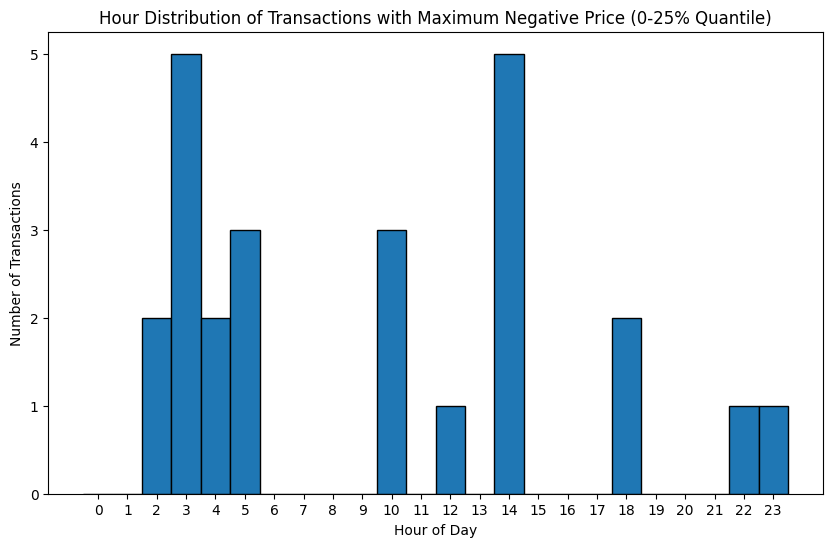

In [ ]:

# ===== Preprocessing and Filtering =====

# Work on a copy of the original dataframe
df = filtered_negative_large_time_diff.copy()

# Convert timestamp columns to datetime
df["DeliveryStart"] = pd.to_datetime(df["DeliveryStart"], errors="coerce")
df["DeliveryEnd"] = pd.to_datetime(df["DeliveryEnd"], errors="coerce")

# Calculate the duration of the transaction in hours
df["Duration_Hours"] = (df["DeliveryEnd"] - df["DeliveryStart"]).dt.total_seconds() / 3600

# Filter out rows with invalid (zero or negative) durations
df = df[df["Duration_Hours"] > 0].copy()

# Calculate Volume Per Hour
df["Volume_Per_Hour"] = df["Volume"] / df["Duration_Hours"]

# ===== Filtering Based on Price Quantile and Volume =====

# Step 1: Filter transactions that are in the 0%-1% price quantile.
low_price_quantile_transactions = df[df["Price_Quantile"] == "0%-1%"].copy()

# Step 2: Further filter for low volume transactions (Volume_Per_Hour <= 0.2 MWh)
matching_transactions = low_price_quantile_transactions[
    low_price_quantile_transactions["Volume_Per_Hour"] <= 0.2
].copy()

# (Optional) Print an aggregated summary of these matching transactions.
matching_summary = pd.DataFrame({
    "Count": [len(matching_transactions)],
    "Avg_Price_Per_MWh": [matching_transactions["price_per_mwh"].mean()],
    "Total_Volume_MWh": [matching_transactions["Volume"].sum()],
    "Total_Price_Volume": [matching_transactions["Price"].sum()]
})
print("Matching Transactions Summary:")
print(matching_summary)

# ===== Identify Transactions with Maximum Negative Price (0-25% Quantile) =====

if not matching_transactions.empty:
    # Create quartile bins (4 bins: 0-25%, 25-50%, 50-75%, 75-100%) based on price_per_mwh
    matching_transactions['Price_Quantile_Bin'] = pd.qcut(
        matching_transactions["price_per_mwh"], q=4, duplicates='drop'
    )
    
    # The lowest quantile (first bin) represents the 0-25% quantile,
    # i.e. transactions with the most negative (lowest) prices.
    lowest_bin = matching_transactions['Price_Quantile_Bin'].cat.categories[0]
    transactions_lowest_quantile = matching_transactions[
        matching_transactions['Price_Quantile_Bin'] == lowest_bin
    ].copy()
else:
    transactions_lowest_quantile = pd.DataFrame()

# ===== Plot the Time Distribution =====

if not transactions_lowest_quantile.empty:
    # Extract the hour of day from the DeliveryStart timestamp.
    transactions_lowest_quantile["Hour"] = transactions_lowest_quantile["DeliveryStart"].dt.hour
    
    # Plot a histogram of the number of transactions by hour of day.
    plt.figure(figsize=(10, 6))
    # Use bins from -0.5 to 23.5 so that each integer hour is centered.
    plt.hist(transactions_lowest_quantile["Hour"], bins=np.arange(-0.5, 24, 1), edgecolor='black')
    plt.title("Hour Distribution of Transactions with Maximum Negative Price (0-25% Quantile)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Transactions")
    plt.xticks(range(0, 24))
    plt.show()
else:
    print("No transactions found in the lowest 25% quantile of matching_transactions.")
